In [ ]:
# dependant packages for data loader
# !pip install torch
# !pip install geopandas
# !pip install rasterio
# !pip install torchvision
# !pip install geographiclib

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

import copy
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools 
from typing import Tuple

import torch

from torch.utils.data import Dataset, Sampler, DataLoader
from scipy import ndimage

import sys
sys.path.append("..")

from src.data.bridge_site import METADATA, TRAIN_DATA, get_dataloaders, DATA_ORDER

In [2]:
# correcting the file paths from ./data/[...] to ../data/[...]
metadata = dict(METADATA)
for country in metadata:
    md = metadata[country]
    for data_name in md:
        data = md[data_name]
        data["fp"] = os.path.join("../", data["fp"])

train_data = dict(TRAIN_DATA)
for version in train_data:
    for tile_size in train_data[version]:
        train_data[version][tile_size] = os.path.join(
            "../", train_data[version][tile_size])

In [226]:
def convert_to_np(data):
    """converts data to numpy array
    
    params:
    split <dataset from loader>: this can be -
           dataloader_train,
           dataloader_validation,
           dataloader_test,
           dataloader_test_rw, or
           dataloader_test_ug
           
    """
    all_data = []
    all_lab = []
    for img, lab in data:
        all_data.append(img)
        all_lab.append(lab)

    all_data = torch.cat(all_data, 0).numpy()
    all_lab = torch.cat(all_lab, 0).numpy()

    print('shape of data', all_data.shape)
    print('shape of labels', all_lab.shape)

    return all_data, all_lab

def index_modalities(dataset):
    img_channels = dataset[:, 1:4, :, :]
    slope_channel = dataset[:, 5:6, :, :]
    water_channel = dataset[:, 7:8, :, :]
    boundry_channel = dataset[:, 8:9, :, :]

    dataset = np.concatenate((img_channels, slope_channel, water_channel, boundry_channel), axis=1)
    return dataset
    

def load_data(tile_size, version, modalities):
    """get data loaders"""
    (dataloader_train, dataloader_validation, dataloader_test,
     dataloader_test_rw, dataloader_test_ug, dataloader_unlab) = get_dataloaders(
    batch_size=64, tile_size=tile_size, train_data=train_data,
    train_metadata=metadata, transform=False, num_workers=0,
    stats_fp="../data/ground_truth/stats.json", use_augment=False,
    drop_last=False, data_version=version)
    
    print('channels:')
    print(dataloader_train.dataset.data_order)
    print('')
    
    print('TRAIN')
    x_train, y_train = convert_to_np(dataloader_train)
    print('VALIDATION')
    x_val, y_val = convert_to_np(dataloader_validation)
    print('TEST')
    x_test, y_test = convert_to_np(dataloader_test)
    print('TEST UGANDA')
    x_test_ug, y_test_ug = convert_to_np(dataloader_test_ug)
    print('RWANDA')
    x_test_rw, y_test_rw = convert_to_np(dataloader_test_rw)
    
    if modalities == 'limited':
        # limited are : admin boundries [8], osm img [1:4], waterways [7], and slope [5]
        x_train = index_modalities(x_train)
        x_val = index_modalities(x_val)
        x_test = index_modalities(x_test)
        x_test_ug = index_modalities(x_test_ug)
        x_test_rw= index_modalities(x_test_rw)
            
    
    return x_train, y_train, x_val, y_val, x_test, y_test, x_test_ug, y_test_ug, x_test_rw, y_test_rw

def reshape_data(x):
    samples = []
    for sample in x:
        channels = []
        for channel in sample:
            channels.append(channel.flatten())
        sample = np.concatenate(channels)  
        sample = np.reshape(sample, (1, len(sample)))
        samples.append(sample)
    samples = np.concatenate(samples, axis=0)


def train_model(x_train, y_train, seed, gridsearch=False):
    if gridsearch:
        pass
    else:
        model = RandomForestClassifier(random_state=seed)
    
    model.fit(reshape_data(x_train), y_train)
    
    return model

def SEM(x):
    return np.std(x) / (np.sqrt(len(x)))

def evaluate_models(model_s1, model_s2, model_s3, x, y):
    
    # seed 1
    y_pred1 = model_s1.predict(reshape_data(x_val), y_val)
    bacc1 = balanced_accuracy_score(y, y_pred1)
    
    # seed 2
    y_pred2 = model_s2.predict(reshape_data(x_val), y_val)
    bacc2 = balanced_accuracy_score(y, y_pred2)
    
    # seed 3
    y_pred3 = model_s3.predict(reshape_data(x_val), y_val)
    bacc3 = balanced_accuracy_score(y, y_pred3)
    
    avg_bacc = np.mean([bacc1, bacc2, bacc3])
    sem_bacc = SEM([bacc1, bacc2, bacc3])
    
    print(f'Balanced Accuracy: {avg_bacc} +/- {sem_bacc}')
                   
    # train with three different seeds
    # predict for each seed model and give pred scores
    
    # get score nd stea
    
# def load, train , pred, eval() # this wi;ll automate the whole thing for linh


In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test, x_test_ug, y_test_ug, x_test_rw, y_test_rw = load_data(tile_size=TILE_SIZE, version=VERSION, modalities=MODALITIES)

In [ ]:

TILE_SIZE= 1200  # or '600' or '300'
VERSION = 'v1'  # or 'v2'
MODALITIES = 'all'  # or 'limited'

# x_train, y_train, x_val, y_val, x_test, y_test, x_test_ug, y_test_ug, x_test_rw, y_test_rw = load_data(tile_size=TILE_SIZE, version=VERSION, modalities=MODALITIES)

model1 = train_model(x_train, y_train, seed=1, gridsearch=False)
model2 = train_model(x_train, y_train, seed=2, gridsearch=False)
model3 = train_model(x_train, y_train, seed=3, gridsearch=False)

evaluate_models(model1, model2, model3, x_val, y_val)

train sampler: 1630 samples in total (815 pos, 815 neg) ([Rwanda] 815 pos 815 neg [Uganda] 0 pos 0 neg)
val sampler: 484 samples in total (242 pos, 242 neg) ([Rwanda] 242 pos 242 neg [Uganda] 0 pos 0 neg)
test sampler: 1240 samples in total (620 pos, 620 neg) ([Rwanda] 370 pos 310 neg [Uganda] 250 pos 310 neg)
test sampler: 740 samples in total (370 pos, 370 neg) ([Rwanda] 370 pos 370 neg [Uganda] 0 pos 0 neg)
test sampler: 500 samples in total (250 pos, 250 neg) ([Rwanda] 0 pos 0 neg [Uganda] 250 pos 250 neg)
channels:
['population', 'osm_img', 'elevation', 'slope', 'roads', 'waterways', 'admin_bounds_qgis']

TRAIN
shape of data (1630, 9, 48, 48)
shape of labels (1630,)
VALIDATION
shape of data (484, 9, 48, 48)
shape of labels (484,)
TEST


In [169]:
train[0].shape

(1630, 9, 48, 48)

In [178]:
sample = train[0][0]
chan1 = sample[0]
chan2 = sample[1]

#for channel in range(9):
    #print(sample)

In [198]:
x = train[0][0:5]

In [199]:
x.shape

(5, 9, 48, 48)

In [224]:

    return samples

reshape_data(train[0]).shape

(1630, 20736)

In [225]:
train[0].shape

(1630, 9, 48, 48)

In [216]:
flat_samp1 = np.concatenate([chan1.flatten(), chan2.flatten()])
flat_samp1  = np.reshape(flat_samp1, (1, len(flat_samp1)))

flat_samp2 = np.concatenate([chan1.flatten(), chan2.flatten()])
flat_samp2 = np.reshape(flat_samp2, (1, len(flat_samp2)))

np.concatenate([flat_samp1, flat_samp2], axis=0).shape

(2, 4608)

In [187]:
flat_samp1.shape


(4608,)

In [190]:
flat_samp1.transpose().shape

(4608,)

In [192]:
np.reshape(flat_samp1, (1, len(flat_samp1))).shape

(1, 4608)

In [177]:
sample.shape

(9, 48, 48)

In [179]:
chan1.shape

(48, 48)

In [181]:
chan2.shape

(48, 48)

In [184]:
chan2.flatten().shape

(2304,)

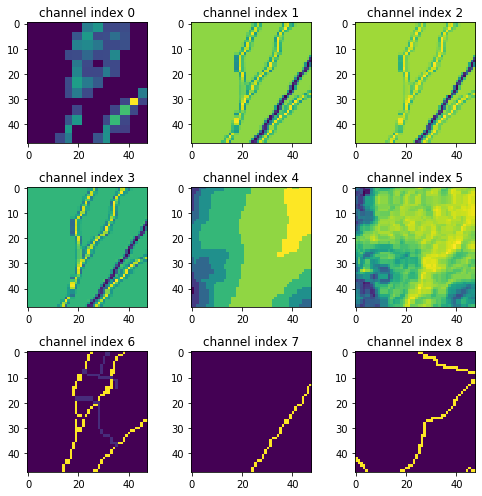

In [59]:
# checking so see if im sliceing right

fig, ax = plt.subplots(3, 3, figsize=(7,7))
for i in range(9):
    title = f"channel index {i}"
    ax.flatten()[i].imshow(train[:, i][15])
    ax.flatten()[i].set_title(title)
fig.tight_layout()

looks like osm_img consist of three channels (R, G, B) I will take all of them.<br> so the limited channel number with be: <br>
osm_img : 1-3 <br>
slope: 5<br>
waterways: 7<br>
admin bounds: 8

In [148]:
# grabbing the channels
img_channel = train[0][:,1:4,:,:]
slope_chan = train[0][:,5:6,:,:]
water_chan = train[0][:,7:8,:,:]
bounds_chan = train[0][:,8:9,:,:]

t = np.concatenate((img_channel, slope_chan, water_chan, bounds_chan), axis=1)

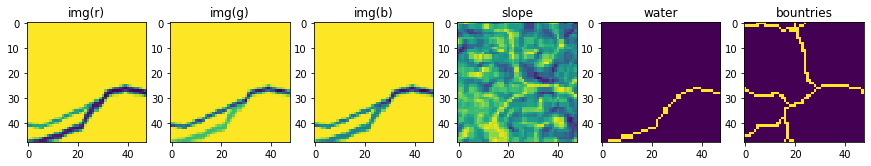

In [161]:
fig, ax = plt.subplots(1, 6, figsize=(15,15))
for i, title in enumerate(['img(r)', 'img(g)', 'img(b)', 'slope', 'water', 'bountries'] ):
    ax[i].imshow(t[15, i])
    ax[i].set_title(title)

In [163]:
train[1]

array([1, 0, 1, ..., 0, 0, 1])

In [140]:
slope_chan.shape

(1630, 1, 48, 48)

In [17]:
data = '300m_v1'
directory = '/home/rachel/Documents/projects/probono/data_as_numpy/'

In [18]:
train = np.load(directory + data + '_train.npy')
val = np.load(directory + data + '_val.npy')

In [19]:
train.shape

(1630, 9, 12, 12)

In [20]:
val.shape

(484, 9, 12, 12)

models:
Model for each tile size and version: 300v1, 300v2, 600v1, 600v2, 1200v1, 1200v2

scores for all the test tests:

ALL MODES
1200v1 both countries: f1+/-ste , bacc+/-ste # 
1200v1 rwanda:         f1+/-ste , bacc+/-ste # i get the ste by useing different seeds to run the code 
1200v1 ug countries:   f1+/-ste , bacc+/-ste
600v1 both countries:  f1+/-ste , bacc+/-ste
600v1 rwanda:          f1+/-ste , bacc+/-ste
600v1 ug :             f1+/-ste , bacc+/-ste
300v1 both countries:  f1+/-ste , bacc+/-ste
300v1 rwanda:          f1+/-ste , bacc+/-ste
300v1 ug countries:    f1+/-ste , bacc+/-ste
1200v2 both countries: f1+/-ste , bacc+/-ste 
1200v2 rwanda:         f1+/-ste , bacc+/-ste
1200v2 ug countries:   f1+/-ste , bacc+/-ste
600v2 both countries:  f1+/-ste , bacc+/-ste
600v2 rwanda:          f1+/-ste , bacc+/-ste
600v2 ug countries:    f1+/-ste , bacc+/-ste
300v2 both countries:  f1+/-ste , bacc+/-ste
300v2 rwanda:          f1+/-ste , bacc+/-ste
300v2 ug countries:    f1+/-ste , bacc+/-ste

LIMITED MODES
1200v1 both countries: f1+/-ste , bacc+/-ste # 
1200v1 rwanda:         f1+/-ste , bacc+/-ste # i get the ste by useing different seeds to run the code 
1200v1 ug countries:   f1+/-ste , bacc+/-ste
600v1 both countries:  f1+/-ste , bacc+/-ste
600v1 rwanda:          f1+/-ste , bacc+/-ste
600v1 ug :             f1+/-ste , bacc+/-ste
300v1 both countries:  f1+/-ste , bacc+/-ste
300v1 rwanda:          f1+/-ste , bacc+/-ste
300v1 ug countries:    f1+/-ste , bacc+/-ste
1200v2 both countries: f1+/-ste , bacc+/-ste 
1200v2 rwanda:         f1+/-ste , bacc+/-ste
1200v2 ug countries:   f1+/-ste , bacc+/-ste
600v2 both countries:  f1+/-ste , bacc+/-ste
600v2 rwanda:          f1+/-ste , bacc+/-ste
600v2 ug countries:    f1+/-ste , bacc+/-ste
300v2 both countries:  f1+/-ste , bacc+/-ste
300v2 rwanda:          f1+/-ste , bacc+/-ste
300v2 ug countries:    f1+/-ste , bacc+/-ste



### notes from meeting with linh:

add to the notebook and work flow the  dataloader  from other notebook. at the first step in training  and predicting so that it can be re ran if we want to use new data

do all the modes and results above for bothe ALL MODALITIES and LIMITED MMODALITIES<br>
- all modalities are listed in the data loader scripts<br>
- limited are : admin bountries, osm img, waterways, ans slope

send lin the resutls as soon as possibl so we can see if they are too good like last time

push changes to notebok to github so that linh can re run the notebook if needed